# Solving Comparing

In [15]:
# Calculating currents in each ring on fft way for anizotropic structure

import numpy as np
import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from Fast_Method import solvesystem as fast_solvesystem
from Straight_Method import solvesystem as straight_solvesystem
from Geometry import Rectangle_packing
from Impedance_matrix import M_diag
from Verifying_MRI.Parameters_MRI import Dz, Dy, Dx, Radius, omega_0, Params
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import json

Params['R'] = 0.002
Params['L'] = 13.459 * 10 ** -9
Params['C'] = 470 * 10 ** -12*100
omega_0 = 1/np.sqrt(Params['L'] * Params['C'])
print(Params)

Inductance = {}
Omega = np.linspace(omega_0*0.9, omega_0*1.1, 1000)
#Omega = np.linspace(4.5 * 2 * np.pi * 1e6, 5 * 2 * np.pi * 1e6, 1000)
H_0z = 1
mu_0 = 4 * np.pi * 1e-7
# Calculate polarisation for different structures

Dz, Dy, Dx = Params['Dz'], Params['Dy'], Params['Dx']
Params['Dz'] = Dy
# Initial position of the first ring for each orientation
R0 = {
    'z': {'nz': 0, 'ny': Dy/2, 'nx': Dx/2},
    'y': {'nz': Dz/2, 'ny': 0, 'nx': Dx/2},
    'x': {'nz': Dz/2, 'ny': Dy/2, 'nx': 0}
}
#Total number of cells for each orientation
N_fft = np.logspace(0.4, 1.6, 20, dtype = int)
TL = 60 * 5
for r in [0.02, 0.01, 0.005, 0.002]:
    Time_fft = []
    Data = {}

    end_fft = 0
    start_fft = 0

    Params['R'] = r
    Q = int(round(omega_0 * Params['L']/Params['R'], 0))
    print('Quaility factor', Q)
    for n in N_fft:
        # FFT method
        if end_fft - start_fft < TL:
            shape = {
                    'z': {'nz': n+1, 'ny': n, 'nx': n},
                    'y': {'nz': n, 'ny': n+1, 'nx': n},
                    'x': {'nz': n, 'ny': n, 'nx': n+1}
                    }
            Params['N'] = shape
            # make 3d structure
            print(f'\n Make rings: {Params["N"]}')
            Rings_4d ={}
            for pos in Params['N']:
                Rings_4d[pos] = Rectangle_packing(Params, r0 = R0[pos], orientation=pos).reshape(
                                                             Params['N'][pos]['nz'],
                                                             Params['N'][pos]['ny'],
                                                             Params['N'][pos]['nx'])
            Rings = np.concatenate([Rings_4d[pos].ravel() for pos in Params['N']])
            Params['Number'] = len(Rings)
            print(Params['Number'])

            phi_0z = np.zeros(Params['Number'])
            Number_z = Params['N']['z']['nz'] * Params['N']['z']['ny'] * Params['N']['z']['nx']
            Number_y = Params['N']['y']['nz'] * Params['N']['y']['ny'] * Params['N']['y']['nx']
            Number_x = Params['N']['x']['nz'] * Params['N']['x']['ny'] * Params['N']['x']['nx']
            phi_0z[:Number_z] = H_0z * mu_0*np.pi * Radius ** 2

            start_fft = timer()
            Currents = fast_solvesystem(Rings_4d, M_diag(Rings, same_rings = True), Omega, phi_0z=H_0z * mu_0*np.pi * Radius ** 2, Inductance = Inductance, tol = 1e-3)
            end_fft = timer()

            Time_fft.append(end_fft - start_fft)

            Nz, Ny, Nx = [Params['N'][pos][f'n{pos}'] for pos in Params['N']]

            P_0z = np.pi * Radius ** 2 /H_0z/Dz/Dy/Dx
            Currents['Params'] = Params
            Currents['RealZPolarisation'] = [P_0z/Number_z * sum(i[:Number_z]) for i in Currents['RealCurrents']]
            Currents['ImagZPolarisation'] = [P_0z/Number_z * sum(i[:Number_z]) for i in Currents['ImagCurrents']]
            Currents['RealYPolarisation'] = [P_0z/Number_y * sum(i[Number_z:Number_z + Number_y]) for i in Currents['RealCurrents']]
            Currents['ImagYPolarisation'] = [P_0z/Number_y * sum(i[Number_z:Number_z + Number_y]) for i in Currents['ImagCurrents']]
            Currents['RealXPolarisation'] = [P_0z/Number_x * sum(i[Number_z + Number_y:]) for i in Currents['RealCurrents']]
            Currents['ImagXPolarisation'] = [P_0z/Number_x * sum(i[Number_z + Number_y:]) for i in Currents['ImagCurrents']]

            exclude = ['RealCurrents', 'ImagCurrents']
            data = {key: value for key, value in Currents.items() if key not in exclude}
            Data[n] = data
        else:
            break

    with open(f'../Data/Time_estimation/Time_fft_zyx.json', 'r') as f:
       Data = json.load(f)
    
    Data[Q]={'Time':Time_fft, 'N': N_fft[:len(Time_fft)].tolist(), 'Data': Data}
    
    with open(f'../Data/Time_estimation/Time_fft_zyx.json', 'w') as f:
       json.dump(Data, f)


{'L': 1.3459e-08, 'C': 4.7000000000000004e-08, 'R': 0.002, 'W': 0.0, 'Radius': 0.004934999999999999, 'Dz': 0.015, 'Dy': 0.015, 'Dx': 0.015, 'N': {'z': {'nz': 3, 'ny': 2, 'nx': 2}, 'y': {'nz': 2, 'ny': 3, 'nx': 2}, 'x': {'nz': 2, 'ny': 2, 'nx': 3}}, 'shift_x': 0, 'shift_y': 0, 'shift_z': 0, 'Orientations': ('x', 'y', 'z'), 'Self-frequence': 392447754.286437, 'Number': 36, 'Responded_x': 0.135, 'Responded_y': -0.015, 'Responded_z': 0.135, 'Responded_pos': 'y', 'Radius_coil': 0.0381, 'L_coil': 1.8e-07, 'C_coil': 10000000000.0, 'R_coil': 1.5, 'W_coil': 0}
Quaility factor 27

 Make rings: {'z': {'nz': 21, 'ny': 20, 'nx': 20}, 'y': {'nz': 20, 'ny': 21, 'nx': 20}, 'x': {'nz': 20, 'ny': 20, 'nx': 21}}
25200
Cirvecs forming


100%|██████████| 3/3 [00:36<00:00, 12.28s/it]


Circvecs: Done
FFT solving


100%|██████████| 1000/1000 [08:43<00:00,  1.91it/s]


FFT solving: Done, shape = [('z', (21, 20, 20)), ('y', (20, 21, 20)), ('x', (20, 20, 21))]
Quaility factor 54

 Make rings: {'z': {'nz': 21, 'ny': 20, 'nx': 20}, 'y': {'nz': 20, 'ny': 21, 'nx': 20}, 'x': {'nz': 20, 'ny': 20, 'nx': 21}}
25200
Cirvecs forming


100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


Circvecs: Done
FFT solving


100%|██████████| 1000/1000 [14:00<00:00,  1.19it/s]


FFT solving: Done, shape = [('z', (21, 20, 20)), ('y', (20, 21, 20)), ('x', (20, 20, 21))]
Quaility factor 107

 Make rings: {'z': {'nz': 21, 'ny': 20, 'nx': 20}, 'y': {'nz': 20, 'ny': 21, 'nx': 20}, 'x': {'nz': 20, 'ny': 20, 'nx': 21}}
25200
Cirvecs forming


100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Circvecs: Done
FFT solving


100%|██████████| 1000/1000 [26:06<00:00,  1.57s/it]


FFT solving: Done, shape = [('z', (21, 20, 20)), ('y', (20, 21, 20)), ('x', (20, 20, 21))]
Quaility factor 178

 Make rings: {'z': {'nz': 21, 'ny': 20, 'nx': 20}, 'y': {'nz': 20, 'ny': 21, 'nx': 20}, 'x': {'nz': 20, 'ny': 20, 'nx': 21}}
25200
Cirvecs forming


100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


Circvecs: Done
FFT solving


100%|██████████| 1000/1000 [53:09<00:00,  3.19s/it] 


FFT solving: Done, shape = [('z', (21, 20, 20)), ('y', (20, 21, 20)), ('x', (20, 20, 21))]


In [244]:
# Calculating currents in each ring on fft way for anizotropic structure

import numpy as np
import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from Fast_Method import solvesystem as fast_solvesystem
from Straight_Method import solvesystem as straight_solvesystem
from Geometry import Rectangle_packing
from Impedance_matrix import M_diag
from Verifying_MRI.Parameters_MRI import Dz, Dy, Dx, Radius, omega_0, Params
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import json

Params['R'] = 0.002
Params['L'] = 13.459 * 10 ** -9
Params['C'] = 470 * 10 ** -12*100
omega_0 = 1/np.sqrt(Params['L'] * Params['C'])
print(Params)

Inductance = {}
Omega = np.linspace(omega_0*0.9, omega_0*1.1, 1000)
#Omega = np.linspace(4.5 * 2 * np.pi * 1e6, 5 * 2 * np.pi * 1e6, 1000)
H_0z = 1
mu_0 = 4 * np.pi * 1e-7
# Calculate polarisation for different structures

Dz, Dy, Dx = Params['Dz'], Params['Dy'], Params['Dx']
Params['Dz'] = Dy
# Initial position of the first ring for each orientation
R0 = {
    'z': {'nz': 0, 'ny': Dy/2, 'nx': Dx/2},
    'y': {'nz': Dz/2, 'ny': 0, 'nx': Dx/2},
    'x': {'nz': Dz/2, 'ny': Dy/2, 'nx': 0}
}
#Total number of cells for each orientation
N_fft = np.logspace(0.4, 1.6, 20, dtype = int)
TL = 60 * 5
for r in [0.02, 0.01, 0.005, 0.002]:
    Time_fft = []
    Data = {}

    end_fft = 0
    start_fft = 0

    Params['R'] = r
    Q = int(round(omega_0 * Params['L']/Params['R'], 0))
    print('Quaility factor', Q)
    for n in N_fft:
        # FFT method
        if end_fft - start_fft < TL:
            shape = {
                    'z': {'nz': n+1, 'ny': n, 'nx': n},
                    }
            Params['N'] = shape
            # make 3d structure
            print(f'\n Make rings: {Params["N"]}')
            Rings_4d ={}
            for pos in Params['N']:
                Rings_4d[pos] = Rectangle_packing(Params, r0 = R0[pos], orientation=pos).reshape(
                                                             Params['N'][pos]['nz'],
                                                             Params['N'][pos]['ny'],
                                                             Params['N'][pos]['nx'])
            Rings = np.concatenate([Rings_4d[pos].ravel() for pos in Params['N']])
            Params['Number'] = len(Rings)
            print(Params['Number'])

            phi_0z = np.zeros(Params['Number'])
            Number_z = Params['N']['z']['nz'] * Params['N']['z']['ny'] * Params['N']['z']['nx']
            Number_y = Params['N']['y']['nz'] * Params['N']['y']['ny'] * Params['N']['y']['nx']
            Number_x = Params['N']['x']['nz'] * Params['N']['x']['ny'] * Params['N']['x']['nx']
            phi_0z[:Number_z] = H_0z * mu_0*np.pi * Radius ** 2

            start_fft = timer()
            Currents = fast_solvesystem(Rings_4d, M_diag(Rings, same_rings = True), Omega, phi_0z=H_0z * mu_0*np.pi * Radius ** 2, Inductance = Inductance, tol = 1e-3)
            end_fft = timer()

            Time_fft.append(end_fft - start_fft)

            Nz, Ny, Nx = [Params['N'][pos][f'n{pos}'] for pos in Params['N']]

            P_0z = np.pi * Radius ** 2 /H_0z/Dz/Dy/Dx
            Currents['Params'] = Params
            Currents['RealZPolarisation'] = [P_0z/Number_z * sum(i[:Number_z]) for i in Currents['RealCurrents']]
            Currents['ImagZPolarisation'] = [P_0z/Number_z * sum(i[:Number_z]) for i in Currents['ImagCurrents']]
            Currents['RealYPolarisation'] = [P_0z/Number_y * sum(i[Number_z:Number_z + Number_y]) for i in Currents['RealCurrents']]
            Currents['ImagYPolarisation'] = [P_0z/Number_y * sum(i[Number_z:Number_z + Number_y]) for i in Currents['ImagCurrents']]
            Currents['RealXPolarisation'] = [P_0z/Number_x * sum(i[Number_z + Number_y:]) for i in Currents['RealCurrents']]
            Currents['ImagXPolarisation'] = [P_0z/Number_x * sum(i[Number_z + Number_y:]) for i in Currents['ImagCurrents']]

            exclude = ['RealCurrents', 'ImagCurrents']
            data = {key: value for key, value in Currents.items() if key not in exclude}
            Data[n] = data
        else:
            break

    with open(f'../Data/Anizo_Time_estimation/Time_fft_zyx.json', 'r') as f:
       Data = json.load(f)
    
    Data[Q]={'Time':Time_fft, 'N': N_fft[:len(Time_fft)].tolist(), 'Data': Data}
    
    with open(f'../Data/Anizo_Time_estimation/Time_fft_zyx.json', 'w') as f:
       json.dump(Data, f)


Quaility factor 268

 Make rings: {'z': {'nz': 2, 'ny': 2, 'nx': 2}}
8
Matrix forming


100%|██████████| 8/8 [00:00<00:00, 1111.92it/s]


Matrix: Done
Straight solving


100%|██████████| 1000/1000 [00:00<00:00, 25363.92it/s]


Straight solving: Done

 Make rings: {'z': {'nz': 3, 'ny': 3, 'nx': 3}}
27
Matrix forming


100%|██████████| 27/27 [00:00<00:00, 2050.63it/s]


Matrix: Done
Straight solving


100%|██████████| 1000/1000 [00:00<00:00, 21541.51it/s]


Straight solving: Done

 Make rings: {'z': {'nz': 4, 'ny': 4, 'nx': 4}}
64
Matrix forming


100%|██████████| 64/64 [00:00<00:00, 2578.46it/s]


Matrix: Done
Straight solving


100%|██████████| 1000/1000 [00:00<00:00, 5429.32it/s]


Straight solving: Done

 Make rings: {'z': {'nz': 5, 'ny': 5, 'nx': 5}}
125
Matrix forming


100%|██████████| 125/125 [00:00<00:00, 791.88it/s]


Matrix: Done
Straight solving


  3%|▎         | 28/1000 [00:01<00:36, 26.74it/s]


KeyboardInterrupt: 

0.02
0.01
0.005
0.003
0.002


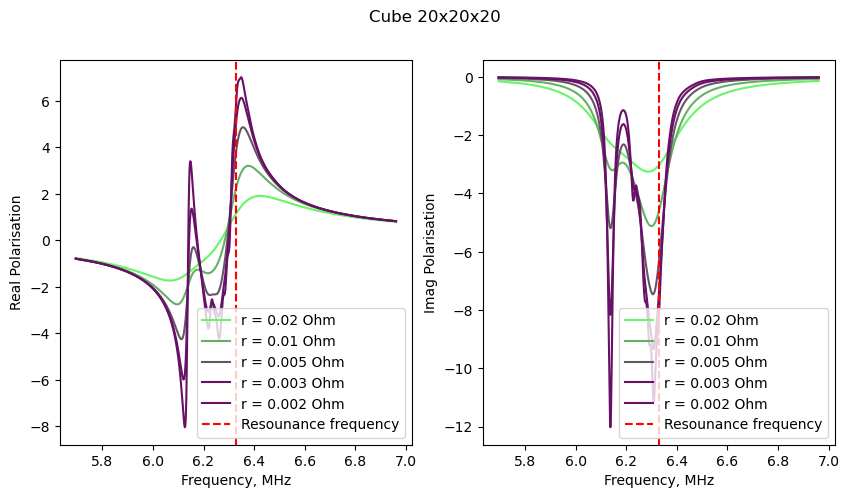

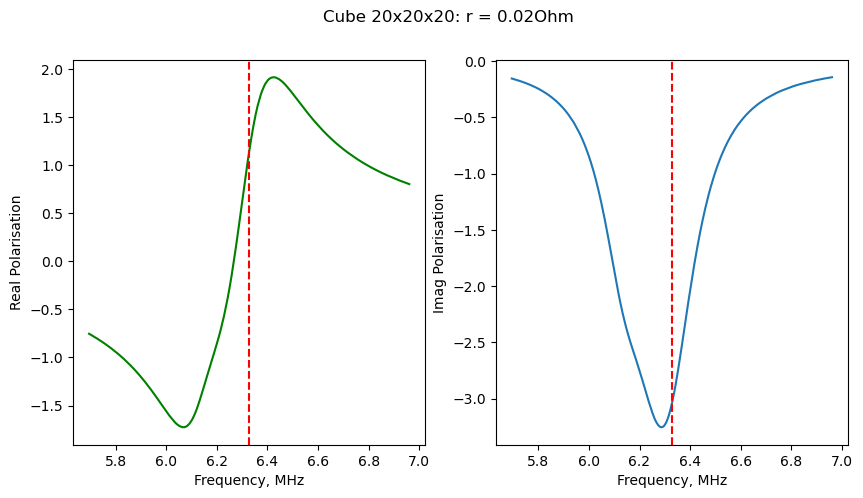

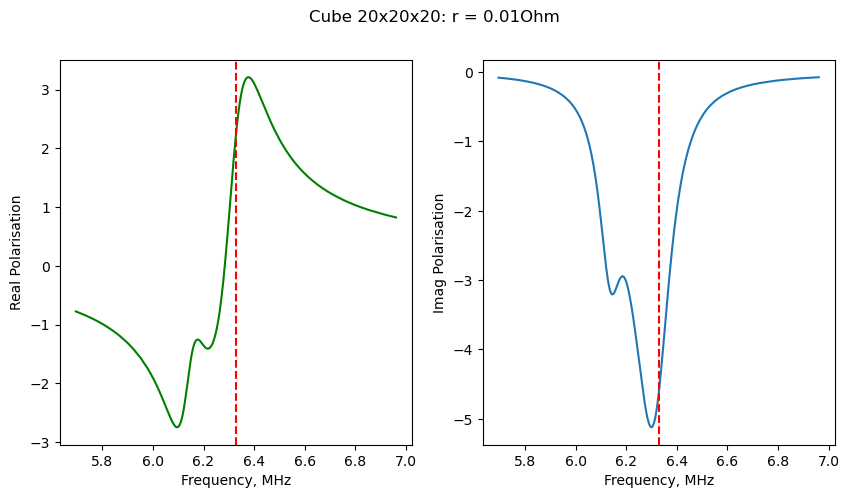

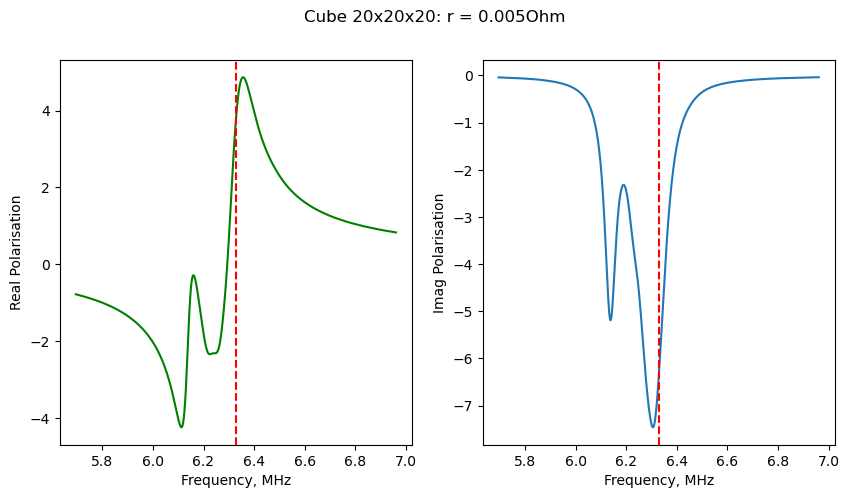

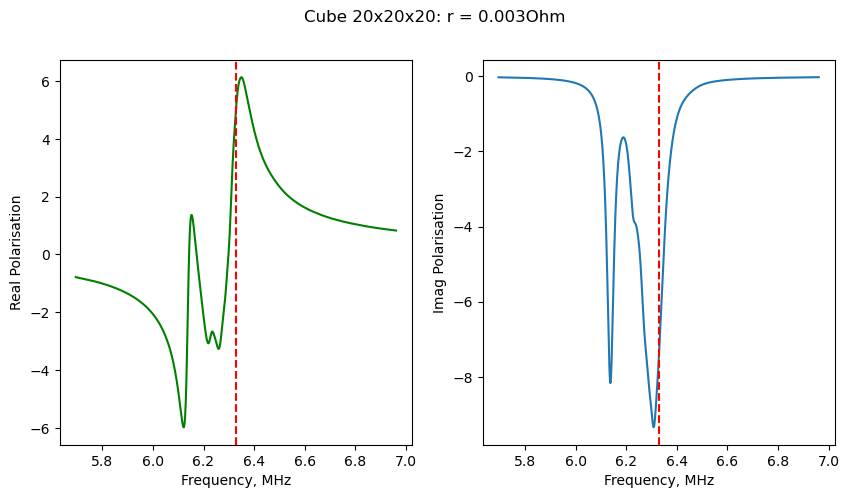

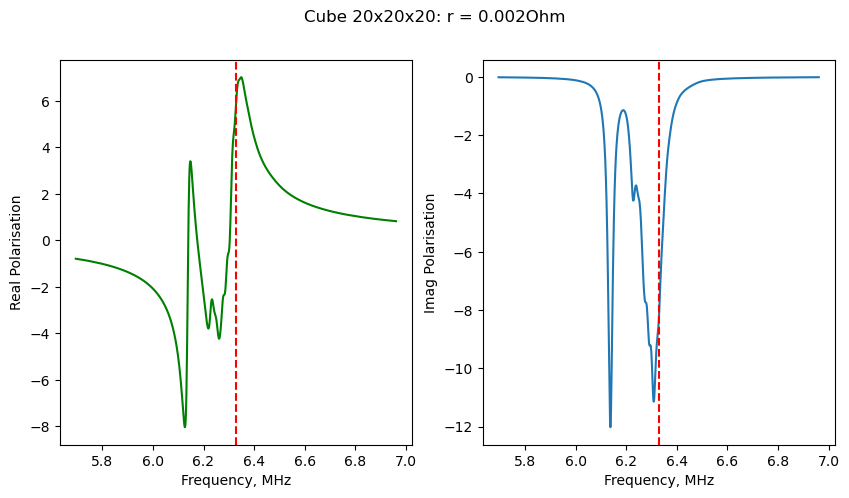

In [21]:
import numpy as np
import json
import matplotlib.pyplot as plt
Params = {}
Params['L'] = 13.459 * 10 ** -9
Params['C'] = 470 * 10 ** -12*100
omega_0 = 1/np.sqrt(Params['L'] * Params['C'])
plt.figure(figsize = (10, 5))
plt.suptitle(f'Cube 20x20x20')
for r in [0.02, 0.01, 0.005, 0.003, 0.002]:
    with open(f'Pol_fft_zyx_20_{r}.json', 'r') as f:
        Currents = json.load(f)

    Omega = np.array(Currents['Omega'])/2/np.pi/1e6
    print(r)
    if r == 0.002:
        RealPolarisation = np.array(Currents['RealZPolarisation'])
        ImagPolarisation = np.array(Currents['ImagZPolarisation'])
    else:   
        RealPolarisation = np.array(Currents['RealPolarisation'])
        ImagPolarisation = np.array(Currents['ImagPolarisation'])



    plt.subplot(121)

    plt.plot(Omega, RealPolarisation, label = f'r = {r} Ohm', color = f'#66{hex(int(np.log(int(r/0.002))*100+16))[-2:]}66')

    plt.subplot(122)

    plt.plot(Omega, ImagPolarisation, label = f'r = {r} Ohm', color = f'#66{hex(int(np.log(int(r/0.002))*100+16))[-2:]}66')



plt.subplot(121)

plt.axvline(omega_0/np.pi/1e6/2, linestyle = '--', color = 'red', label = 'Resounance frequency')
plt.xlabel('Frequency, MHz')
plt.ylabel('Real Polarisation')
plt.legend()

plt.subplot(122)

plt.axvline(omega_0/np.pi/1e6/2, linestyle = '--', color = 'red', label = 'Resounance frequency')
plt.xlabel('Frequency, MHz')
plt.ylabel('Imag Polarisation')
plt.legend()
plt.show()


for r in [0.02, 0.01, 0.005, 0.003, 0.002]:
    with open(f'Pol_fft_zyx_20_{r}.json', 'r') as f:
        Currents = json.load(f)

    Omega = np.array(Currents['Omega'])/2/np.pi/1e6
    if r == 0.002:
        RealPolarisation = np.array(Currents['RealZPolarisation'])
        ImagPolarisation = np.array(Currents['ImagZPolarisation'])
    else:   
        RealPolarisation = np.array(Currents['RealPolarisation'])
        ImagPolarisation = np.array(Currents['ImagPolarisation'])

    plt.figure(figsize = (10, 5))
    plt.suptitle(f'Cube 20x20x20: r = {r}Ohm')

    plt.subplot(121)

    plt.plot(Omega, RealPolarisation, color = 'green')
    plt.axvline(omega_0/np.pi/1e6/2, linestyle = '--', color = 'red')
    plt.xlabel('Frequency, MHz')
    plt.ylabel('Real Polarisation')

    plt.subplot(122)

    plt.plot(Omega, ImagPolarisation)
    plt.axvline(omega_0/np.pi/1e6/2, linestyle = '--', color = 'red')

    plt.xlabel('Frequency, MHz')
    plt.ylabel('Imag Polarisation')
    plt.show()



[2.21024486e-05 2.17600107e+00]
1 million rings
Q = 11
 FFT:0.23 hours 
 Straight: 7.97 years
[0.00602989 0.49323111 1.        ]
1 million rings
Q = 54
 FFT:0.64 hours 
 Straight: 7.97 years
[0.0011855  0.68645692 1.        ]
1 million rings
Q = 268
 FFT:13.89 hours 
 Straight: 7.97 years
[1.10507183e-04 1.08052071e+00 1.00000000e+00]
1 million rings
Q = 1070
 FFT:2.8 hours 
 Straight: 7.97 years
[0.05702179 0.51257868 1.        ]


/opt/homebrew/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


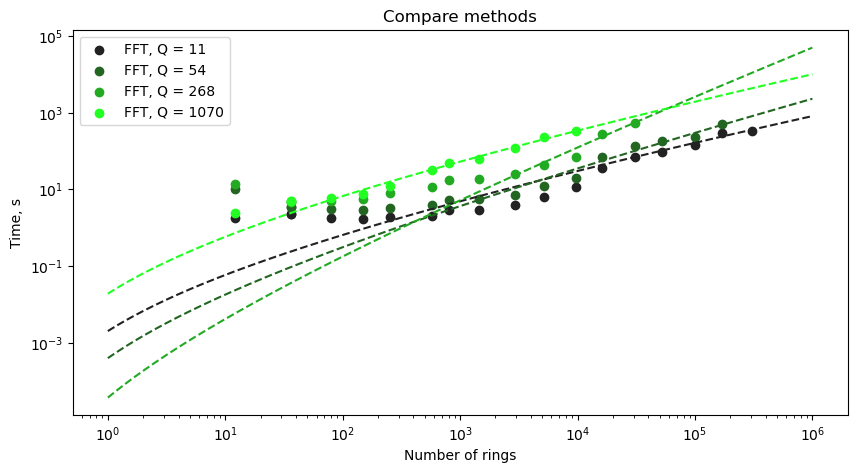

In [27]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import json

def nlogn(x, a, n, b):
    return a*x**n*(np.log(2*np.power(x, 1/3)))**3
def poly(x, a, n):
    return abs(a)*x**n + Time_straight[0]
def linear(x, a, b):
    return a*x + b

# Find degree of polinomial dependence for straight method

with open('Time_straight.json', 'r') as f:
    Q = 268
    Data = json.load(f)
    Time_straight = Data[str(Q)]['Time']
    N_straight = np.array(Data[str(Q)]['N'])

popt_straight, pcov_straight = curve_fit(poly, N_straight[-6:] ** 3, Time_straight[-6:])
print(popt_straight)

plt.figure(figsize=(10, 5))
plt.title('Compare methods')
#plt.plot(np.logspace(0, 6, 1000), poly(np.logspace(0, 6, 1000), *popt_straight), color = 'b', linestyle = '--', label = f'$N^2$ fit')
#plt.scatter(N_straight**3, Time_straight, label='Straight', color = 'b')
#plt.axhline(60*5, color = 'r', linestyle = '--')
#plt.axvline((N_straight[-1])**3, color = 'r', linestyle = '--')
#plt.text(1.1*N_straight[len(Time_straight)-1]**3, Q, f'N = {N_straight[len(Time_straight)-1]**3}', color = 'r')
for Q, color  in zip([11, 54, 268, 1070], ['#222222', '#226622', '#22AA22', '#22FF22']):
    with open('Time_fft_z.json', 'r') as f:
        Data = json.load(f)
        Time_fft = Data[str(Q)]['Time']
        N_fft = np.array(Data[str(Q)]['N'])

    Number = (N_fft + 1) * N_fft * N_fft
    
    popt, pcov = curve_fit(nlogn, Number[-6:], Time_fft[-6:])

    # Compare time
    plt.scatter(Number, Time_fft, label=f'FFT, Q = {Q}', color = color)
    plt.plot(np.logspace(0, 6, 1000), nlogn(np.logspace(0, 6, 1000), *popt), color = color, linestyle = '--')#, label = f'$N \log N$ fit')
    
    #plt.axvline(Number[-1]*3, color = 'r', linestyle = '--')

    #plt.text(1.1*N_fft[len(Time_fft)-1]**3, Q, f'N = {N_fft[len(Time_fft)-1]**3}', color = 'r')
    
    plt.xlabel('Number of rings')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('Time, s')
    plt.legend()
    print('1 million rings')
    print(f'Q = {Q}\n FFT:{round(nlogn(1e6, *popt)/3600, 2)} hours \n Straight: {round(poly(1e6, *popt_straight)/3600/24/365, 2)} years')
    print(popt)
    
    
        

# Multiplying comparing

In [ ]:
# Calculating currents in each ring on pyfftw way (one dimensional)

import numpy as np
from Impedance_matrix import Mnm, Matrix
from pyfftw import pyfftw
from scipy.sparse.linalg import LinearOperator
from tqdm import tqdm

# Function for creating circulant vectors
def Circvec(rings_3d_str, rings_3d_col, data):
    Nz_str, Ny_str, Nx_str = rings_3d_str.shape
    Nz_col, Ny_col, Nx_col = rings_3d_col.shape
    nz, ny, nx = Nz_str + Nz_col - 1, Ny_str + Ny_col - 1, Nx_str + Nx_col - 1
    Z_circvecs = pyfftw.empty_aligned((nz, ny, nx), dtype = 'complex128')
    for z in range(nz):
        for y in range(ny):
            for x in range(nx):
                x_str_id = (nx - x) * (x >= Nx_col)
                x_col_id = x * (x < Nx_col)

                y_str_id = (ny - y) * (y >= Ny_col)
                y_col_id = y * (y < Ny_col)

                z_str_id = (nz - z) * (z >= Nz_col)
                z_col_id = z * (z < Nz_col)
                
                Z_circvecs[z][y][x] = Mnm(rings_3d_str[z_str_id][y_str_id][x_str_id], rings_3d_col[z_col_id][y_col_id][x_col_id], data)
    return Z_circvecs

def fft_dot(I, ZI, FFT_Z_circvecs, i_vecs, ifft_i_vecs):
    Nz, Ny, Nx = I.shape
    nz, ny, nx = i_vecs.shape

    i_vecs[:Nz, :Ny, :Nx] = I

    pyfftw.FFTW(i_vecs, ifft_i_vecs, axes = (0, 1, 2), direction='FFTW_BACKWARD', threads = 8).execute()
    pyfftw.FFTW(FFT_Z_circvecs * ifft_i_vecs/nz/ny/nx, ZI, axes = (0, 1, 2), threads = 8).execute()
    
    return ZI[:nz - Nz + 1, :ny - Ny + 1, :nx - Nx + 1].ravel()

def Matrix_fft(rings_4d, Inductance = {}):
    orientations = rings_4d.keys()
    Number = np.sum([value.size for value in rings_4d.values()])

    FFT_M_circvecs = {}
    i_vecs = {}
    ifft_i_vecs = {}
    MI_vecs = {}

    # Preparing empty arrays for pyfftw
    print('Cirvecs forming')
    for pos_str in tqdm(orientations):
        rings_str = rings_4d[pos_str]
        FFT_M_circvecs[pos_str] = {}
        i_vecs[pos_str] = {}
        ifft_i_vecs[pos_str] = {}
        MI_vecs[pos_str] = {}
        for pos_col in orientations:
            rings_col = rings_4d[pos_col]
            M_circvecs = Circvec(rings_str, rings_col, Inductance)

            N_circ = np.array(rings_str.shape) + np.array(rings_col.shape) - 1
            i_vecs[pos_str][pos_col] = np.zeros(N_circ, dtype=complex)
            MI_vecs[pos_str][pos_col] = pyfftw.empty_aligned(N_circ, dtype = 'complex128')

            FFT_M_circvecs[pos_str][pos_col] = pyfftw.empty_aligned(N_circ, dtype = 'complex128')
            ifft_i_vecs[pos_str][pos_col] = pyfftw.empty_aligned(N_circ, dtype = 'complex128')
            pyfftw.FFTW(M_circvecs, FFT_M_circvecs[pos_str][pos_col], axes = (0, 1, 2), threads = 8).execute()
    print('Circvecs: Done')

    def LO(I):
        MI = np.zeros_like(I, dtype = complex)
        # Make start and end indexes for each orientation
        start_str = 0
        end_str = 0
        for pos_str in orientations:
            end_str += rings_4d[pos_str].size
            start_col = 0
            end_col = 0
            for pos_col in orientations:
                end_col += rings_4d[pos_col].size
                MI[start_str: end_str] -= fft_dot(I[start_col:end_col].reshape(rings_4d[pos_col].shape),
                                                  MI_vecs[pos_str][pos_col],
                                                  FFT_M_circvecs[pos_str][pos_col],
                                                  i_vecs[pos_str][pos_col],
                                                  ifft_i_vecs[pos_str][pos_col])
                start_col += rings_4d[pos_col].size
            start_str += rings_4d[pos_str].size
        return MI
        
    M = LinearOperator(dtype = np.complex128, shape=(Number, Number), matvec=LO)
    return M

In [ ]:
import numpy as np
# Calculating currents in each ring on fft way for anizotropic structure

import numpy as np
import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

# Calculating currents in each ring on fft way for border structure, but with fixed number of rings
import numpy as np
from Fast_Method import solvesystem
from Geometry import Rectangle_packing
from Impedance_matrix import M_grad
from Verifying_MRI.Parameters_MRI import Dz, Dy, Dx, Radius, omega_0, Params
from timeit import default_timer as timer
from tqdm import tqdm
Params['R'] = 0.002
Params['L'] = 13.459 * 10 ** -9
Params['C'] = 470 * 10 ** -12*100
omega_0 = 1/np.sqrt(Params['L'] * Params['C'])
import json

Inductance = {}
omega_0 = 1/np.sqrt(Params['L'] * Params['C'])
Omega =  np.linspace(omega_0*0.9, omega_0*1.1, 1000)
H_0z = 1
mu_0 = 4 * np.pi * 1e-7
# Calculate polarisation for different structures

Dz, Dy, Dx = Params['Dz'], Params['Dy'], Params['Dx']
# Initial position of the first ring for each orientation
R0 = {
    'z': {'nz': 0, 'ny': Dy/2, 'nx': Dx/2},
    'y': {'nz': Dz/2, 'ny': 0, 'nx': Dx/2},
    'x': {'nz': Dz/2, 'ny': Dy/2, 'nx': 0}
}

N_straight = np.logspace(0.4, 3, 20, dtype = int)
N_izo = np.logspace(0.4, 3, 20, dtype = int)
N_anizo = np.logspace(0.4, 3, 20, dtype = int)

TL = 1

Time = {
    'Straight': {'time': [], 'N': []},
    'izo-FFT': {'time': [], 'N': []},
    'anizo-FFT': {'time': [], 'N': []}
}
# Straight method
start_straight = 0
end_straight = 0

for n in tqdm(N_straight):
    if end_straight - start_straight < TL:
        Params['N'] = {'z':{'nz': n+1, 'ny': n, 'nx': n},
                       'y':{'nz': n, 'ny': n+1, 'nx': n},
                       'x':{'nz': n, 'ny': n, 'nx': n+1}}
        Rings_4d = {}
        for pos in Params['N']:
            Rings_4d[pos] = Rectangle_packing(Params, r0 = R0[pos], orientation=pos).reshape(
                                                                 Params['N'][pos]['nz'],
                                                                 Params['N'][pos]['ny'],
                                                                 Params['N'][pos]['nx'])
        Rings = np.concatenate([Rings_4d[pos].ravel() for pos in Params['N']])
        
        M = np.diag(M_diag(Rings, same_rings=True)) - Matrix(Rings, Data=Inductance)
        I = np.random.rand(Params['Number']) + 1j * np.random.randn(Params['Number'])
        start_straight = timer()
        M @ I
        end_straight = timer()
        Time['Straight']['time'].append(end_straight - start_straight)
        Time['Straight']['N'].append(Params['Number'])
    else:
        break
# FFT method for anisotropic structure
start_izo = 0
end_izo = 0

for n in tqdm(N_anizo):
    if end_izo - start_izo < TL:
        Params['N'] = {'z':{'nz': n+1, 'ny': n, 'nx': n},
                       'y':{'nz': n, 'ny': n+1, 'nx': n},
                       'x':{'nz': n, 'ny': n, 'nx': n+1}}
        Rings_4d = {}
        for pos in Params['N']:
            Rings_4d[pos] = Rectangle_packing(Params, r0 = R0[pos], orientation=pos).reshape(
                                                                 Params['N'][pos]['nz'],
                                                                 Params['N'][pos]['ny'],
                                                                 Params['N'][pos]['nx'])
        Rings = np.concatenate([Rings_4d[pos].ravel() for pos in Params['N']])

        M = Matrix_fft(Rings_4d, Data=Inductance)
        I = np.random.rand(Params['Number']) + 1j * np.random.randn(Params['Number'])
        start_izo = timer()
        M @ I + M_diag(Rings, same_rings=True) @ I
        end_izo = timer()
        Time['izo-FFT']['time'].append(end_izo - start_izo)
        Time['izo-FFT']['N'].append(Params['Number'])
    else:
        break

# FFT method for isotropic structure

start_anizo = 0
end_anizo = 0

for n in tqdm(N_anizo):
    if end_anizo - start_anizo < TL:
        Params['N'] = {'z':{'nz': n+1, 'ny': n, 'nx': n}}
        Rings_4d = {}
        for pos in Params['N']:
            Rings_4d[pos] = Rectangle_packing(Params, r0 = R0[pos], orientation=pos).reshape(
                                                                 Params['N'][pos]['nz'],
                                                                 Params['N'][pos]['ny'],
                                                                 Params['N'][pos]['nx'])
        Rings = np.concatenate([Rings_4d[pos].ravel() for pos in Params['N']])

        M = Matrix_fft(Rings_4d, Data=Inductance)
        I = np.random.rand(Params['Number']) + 1j * np.random.randn(Params['Number'])
        start_anizo = timer()
        M @ I + M_diag(Rings, same_rings=True) @ I
        end_anizo = timer()
        Time['anizo-FFT']['time'].append(end_anizo - start_anizo)
        Time['anizo-FFT']['N'].append(Params['Number'])
    else:
        break

with open('../Data/Time_estimation/M-Time.json', 'w') as f:
    json.dump(Time, f)

# Comparing Fouriers in different libraries 

In [143]:
#Checking fft method for multiplying

import pyfftw
from scipy.fft import fftn, ifftn
#ZI_circ = fftn(fftn(Z_circvecs) * ifftn(i_vecs))

A = np.array([[1, 2, 3], [3, 1, 2], [2, 3, 1]], dtype=np.complex128)
Circ = np.array([1, 2, 3], dtype = np.complex128)
Circ2 = np.array([1, 3, 2], dtype = np.complex128)
I  = np.array([1, 7, 0], dtype=np.complex128)
B = A.dot(I)
print(B)
ifft_I = pyfftw.empty_aligned(3, dtype = 'complex128')
fft_Circ = pyfftw.empty_aligned(3, dtype = 'complex128')
fft_B = pyfftw.empty_aligned(3, dtype = 'complex128')
pyfftw.FFTW(I, ifft_I).execute()
pyfftw.FFTW(Circ2, fft_Circ).execute()
pyfftw.FFTW(fft_Circ * ifft_I, fft_B, direction = 'FFTW_BACKWARD').execute()
print(fft_B/3)
print(ifftn(fftn(I) * fftn(Circ2)))






[15.+0.j 10.+0.j 23.+0.j]
[15.+0.j 10.+0.j 23.+0.j]
[15.+0.j 10.+0.j 23.+0.j]


In [233]:
# comparing fft methods
import pyfftw, numpy as np, scipy
from timeit import default_timer as timer
import torch
import matplotlib.pyplot as plt

def pyfftw_fftn(a, s=None, axes=None, overwrite_input=False, planner_effort='FFTW_MEASURE', threads=None, auto_align_input=True, auto_contiguous=True, avoid_copy=False):
    return pyfftw.interfaces.numpy_fft.fftn(a, s, axes, overwrite_input=overwrite_input, planner_effort=planner_effort, threads=threads, auto_align_input=auto_align_input, auto_contiguous=auto_contiguous)

def np_fftn(a, s=None, axes=None, norm=None):
    return np.fft.fftn(a, s, axes)

def scipy_fftn(a, s=None, axes=None, norm=None, workers=1):
    return scipy.fft.fftn(a, s, axes = axes, workers = workers)

def torch_fftn(a, s=None, axes=None, norm=None):
    return torch.fft.fftn(a, s, dim=axes)

time_pyfftw_threaded = []
time_pyfftw_interfaces_threaded = []
time_pyfftw_interfaces = []
time_pyfftw = []
time_scipy_threaded = []
time_scipy = []
time_torch_threaded = []
time_torch = []
time_numpy = []
repeat_time = 10

for n in range(1, 5):
    print('\n', n, '\n')
    axes = tuple(range(n))
    for _ in range(repeat_time):
        a_np = (np.random.rand(100**n) + 1j * np.random.rand(100**n)).reshape((100,)*n)

        a = pyfftw.empty_aligned((100,)*n, dtype='complex128')
        b = pyfftw.empty_aligned((100,)*n, dtype='complex128')
        a[:] = a_np
        

        start = timer() 
        pyfftw_fftn(a, axes = axes, threads=8)
        end = timer()

        time_pyfftw_interfaces_threaded.append((end - start)/repeat_time)

        start = timer()
        pyfftw.FFTW(a, b, axes = axes, threads = 8).execute()
        end = timer()

        time_pyfftw_threaded.append((end - start)/repeat_time)


        start = timer() 
        pyfftw_fftn(a, axes = axes, threads=1)
        end = timer()

        time_pyfftw_interfaces.append((end - start)/repeat_time)

        start = timer()
        pyfftw.FFTW(a, b, axes = axes, threads = 1).execute()
        end = timer()

        time_pyfftw.append((end - start)/repeat_time)

        start = timer()
        scipy_fftn(a, workers=8, axes = axes)
        end = timer()

        time_scipy_threaded.append((end - start)/repeat_time)

        start = timer()
        scipy_fftn(a, workers=1, axes = axes)
        end = timer()

        time_scipy.append((end - start)/repeat_time)

        a_t = torch.from_numpy(a_np)
        torch.set_num_threads(8)
        start = timer()
        torch_fftn(a_t, axes = axes)
        end = timer()

        time_torch.append((end - start)/repeat_time)

        a_t = torch.from_numpy(a_np)
        torch.set_num_threads(8)
        start = timer()
        torch_fftn(a_t, axes = axes)
        end = timer()

        time_torch_threaded.append((end - start)/repeat_time)

        start = timer()
        np_fftn(a_np, axes = axes)
        end = timer()

        time_numpy.append((end - start)/repeat_time)

def average(lst, repeat_time):
    arr = np.array(lst).reshape((len(lst)//repeat_time, repeat_time))
    return np.sum(arr, axis=1)



 1 


 2 


 3 


 4 



pyfftw_threaded
 [2.14162396e-04 7.22850097e-04 5.57233330e-03 3.00964908e-01]
pyfftw_interfaces_threaded
 [8.34920901e-04 1.29240830e-03 1.17587747e-02 1.26532724e+00]
pyfftw_interfaces
 [3.54966498e-04 9.06179202e-04 1.42708205e-02 3.49449951e+00]
pyfftw
 [3.66915046e-05 2.32912594e-04 1.13384709e-02 1.25399827e+00]
scipy_threaded
 [2.19679202e-04 4.84033304e-04 1.03005750e-02 4.07431171e-01]
scipy
 [2.88959040e-05 2.77766792e-04 1.24889793e-02 1.46232303e+00]
torch_threaded
 [1.07875036e-05 1.80029403e-04 1.40865293e-02 1.50504575e+00]
torch
 [8.59209948e-05 2.54075200e-04 1.48776042e-02 1.68134919e+00]
numpy
 [6.24500972e-05 2.54004099e-04 1.90674252e-02 2.63235620e+00]


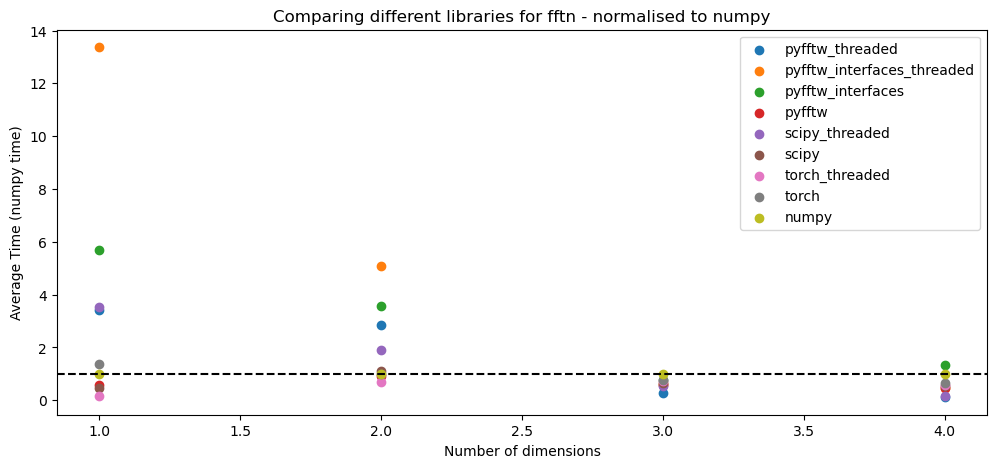

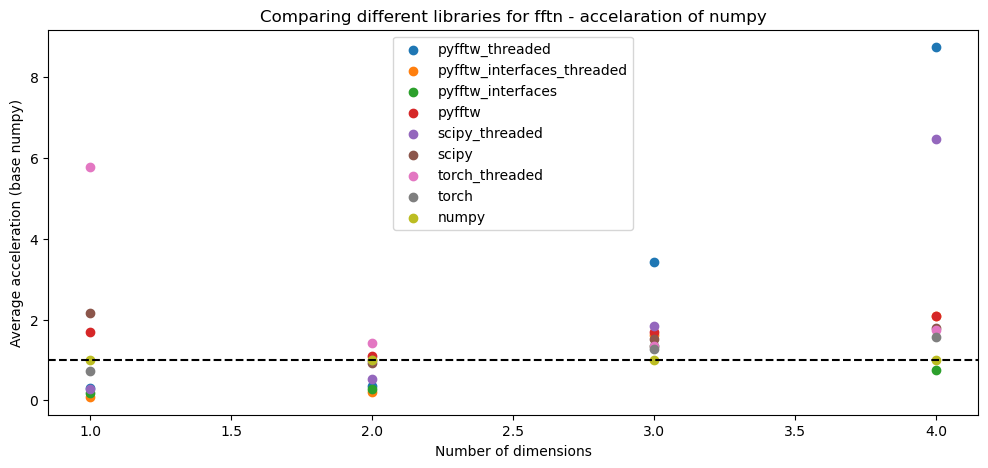

In [240]:

print('pyfftw_threaded\n', average(time_pyfftw_threaded, repeat_time))
print('pyfftw_interfaces_threaded\n', average(time_pyfftw_interfaces_threaded, repeat_time))
print('pyfftw_interfaces\n', average(time_pyfftw_interfaces, repeat_time))
print('pyfftw\n', average(time_pyfftw, repeat_time))
print('scipy_threaded\n', average(time_scipy_threaded, repeat_time))
print('scipy\n', average(time_scipy, repeat_time))
print('torch_threaded\n', average(time_torch_threaded, repeat_time))
print('torch\n', average(time_torch, repeat_time))
print('numpy\n', average(time_numpy, repeat_time))

plt.figure(figsize=(12, 5))
plt.title('Comparing different libraries for fftn - normalised to numpy')
plt.ylabel('Average Time (numpy time)')
plt.xlabel('Number of dimensions')
one = average(time_numpy, repeat_time)
plt.scatter(range(1, 5), average(time_pyfftw_threaded, repeat_time)/one, label='pyfftw_threaded')
plt.scatter(range(1, 5), average(time_pyfftw_interfaces_threaded, repeat_time)/one, label='pyfftw_interfaces_threaded')
plt.scatter(range(1, 5), average(time_pyfftw_interfaces, repeat_time)/one, label='pyfftw_interfaces')
plt.scatter(range(1, 5), average(time_pyfftw, repeat_time)/one, label='pyfftw')
plt.scatter(range(1, 5), average(time_scipy_threaded, repeat_time)/one, label='scipy_threaded')
plt.scatter(range(1, 5), average(time_scipy, repeat_time)/one, label='scipy')
plt.scatter(range(1, 5), average(time_torch_threaded, repeat_time)/one, label='torch_threaded')
plt.scatter(range(1, 5), average(time_torch, repeat_time)/one, label='torch')
plt.scatter(range(1, 5), average(time_numpy, repeat_time)/one, label='numpy')
plt.axhline(1, color='black', linestyle='--')   

plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.title('Comparing different libraries for fftn - accelaration of numpy')
plt.ylabel('Average acceleration (base numpy)')
plt.xlabel('Number of dimensions')
one = average(time_numpy, repeat_time)
plt.scatter(range(1, 5), one/average(time_pyfftw_threaded, repeat_time), label='pyfftw_threaded')
plt.scatter(range(1, 5), one/average(time_pyfftw_interfaces_threaded, repeat_time), label='pyfftw_interfaces_threaded')
plt.scatter(range(1, 5), one/average(time_pyfftw_interfaces, repeat_time), label='pyfftw_interfaces')
plt.scatter(range(1, 5), one/average(time_pyfftw, repeat_time), label='pyfftw')
plt.scatter(range(1, 5), one/average(time_scipy_threaded, repeat_time), label='scipy_threaded')
plt.scatter(range(1, 5), one/average(time_scipy, repeat_time), label='scipy')
plt.scatter(range(1, 5), one/average(time_torch_threaded, repeat_time), label='torch_threaded')
plt.scatter(range(1, 5), one/average(time_torch, repeat_time), label='torch')
plt.scatter(range(1, 5), one/average(time_numpy, repeat_time), label='numpy')
plt.axhline(1, color='black', linestyle='--')   

plt.legend()
plt.show()


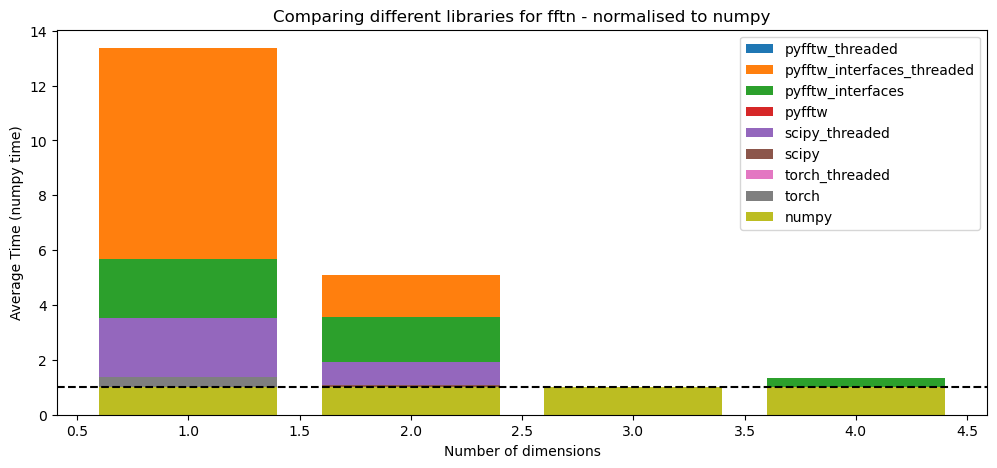

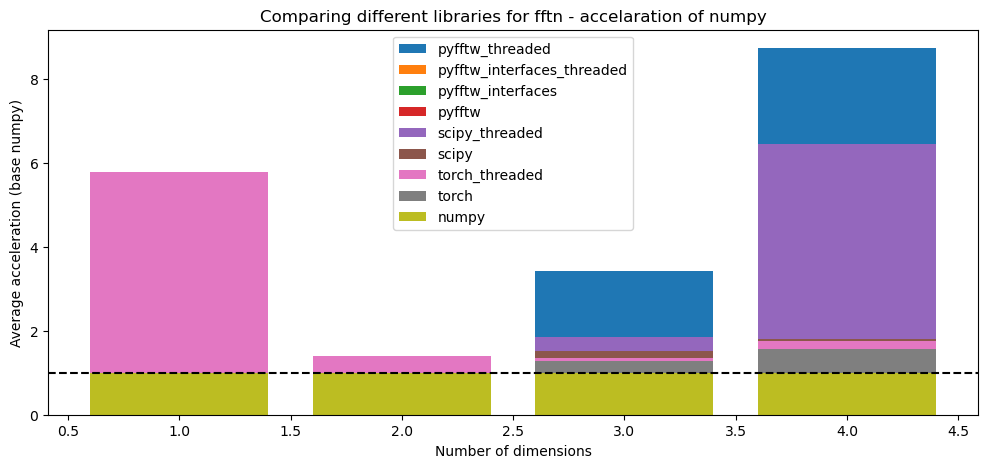

In [241]:


plt.figure(figsize=(12, 5))
plt.title('Comparing different libraries for fftn - normalised to numpy')
plt.ylabel('Average Time (numpy time)')
plt.xlabel('Number of dimensions')
one = average(time_numpy, repeat_time)
plt.bar(range(1, 5), average(time_pyfftw_threaded, repeat_time)/one, label='pyfftw_threaded')
plt.bar(range(1, 5), average(time_pyfftw_interfaces_threaded, repeat_time)/one, label='pyfftw_interfaces_threaded')
plt.bar(range(1, 5), average(time_pyfftw_interfaces, repeat_time)/one, label='pyfftw_interfaces')
plt.bar(range(1, 5), average(time_pyfftw, repeat_time)/one, label='pyfftw')
plt.bar(range(1, 5), average(time_scipy_threaded, repeat_time)/one, label='scipy_threaded')
plt.bar(range(1, 5), average(time_scipy, repeat_time)/one, label='scipy')
plt.bar(range(1, 5), average(time_torch_threaded, repeat_time)/one, label='torch_threaded')
plt.bar(range(1, 5), average(time_torch, repeat_time)/one, label='torch')
plt.bar(range(1, 5), average(time_numpy, repeat_time)/one, label='numpy')
plt.axhline(1, color='black', linestyle='--')   

plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.title('Comparing different libraries for fftn - accelaration of numpy')
plt.ylabel('Average acceleration (base numpy)')
plt.xlabel('Number of dimensions')
one = average(time_numpy, repeat_time)
plt.bar(range(1, 5), one/average(time_pyfftw_threaded, repeat_time), label='pyfftw_threaded')
plt.bar(range(1, 5), one/average(time_pyfftw_interfaces_threaded, repeat_time), label='pyfftw_interfaces_threaded')
plt.bar(range(1, 5), one/average(time_pyfftw_interfaces, repeat_time), label='pyfftw_interfaces')
plt.bar(range(1, 5), one/average(time_pyfftw, repeat_time), label='pyfftw')
plt.bar(range(1, 5), one/average(time_scipy_threaded, repeat_time), label='scipy_threaded')
plt.bar(range(1, 5), one/average(time_scipy, repeat_time), label='scipy')
plt.bar(range(1, 5), one/average(time_torch_threaded, repeat_time), label='torch_threaded')
plt.bar(range(1, 5), one/average(time_torch, repeat_time), label='torch')
plt.bar(range(1, 5), one/average(time_numpy, repeat_time), label='numpy')
plt.axhline(1, color='black', linestyle='--')   

plt.legend()
plt.show()


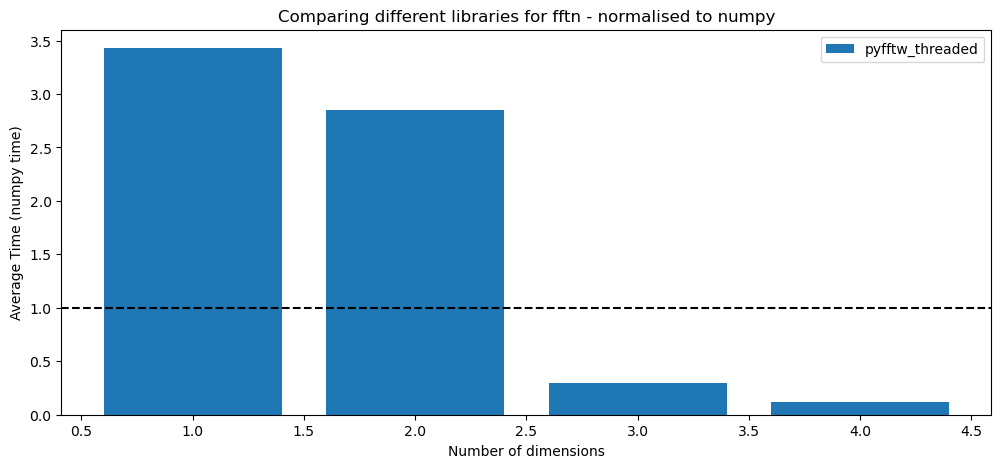

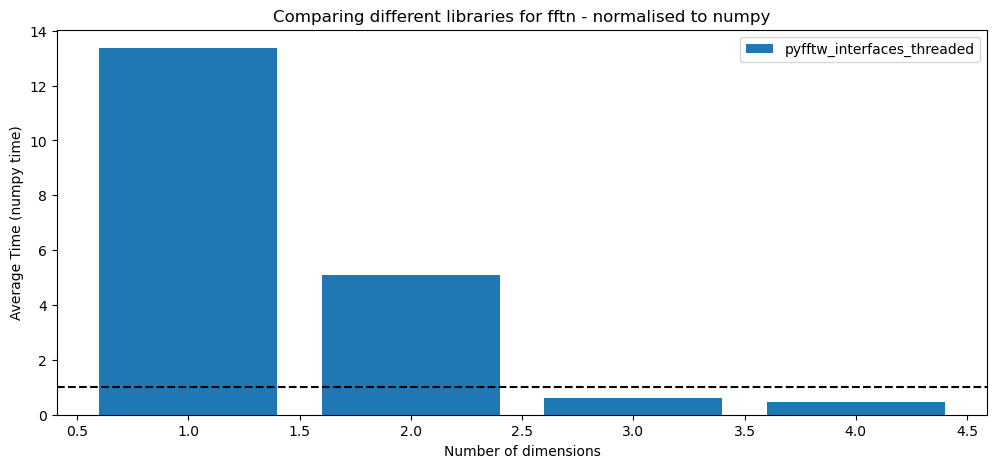

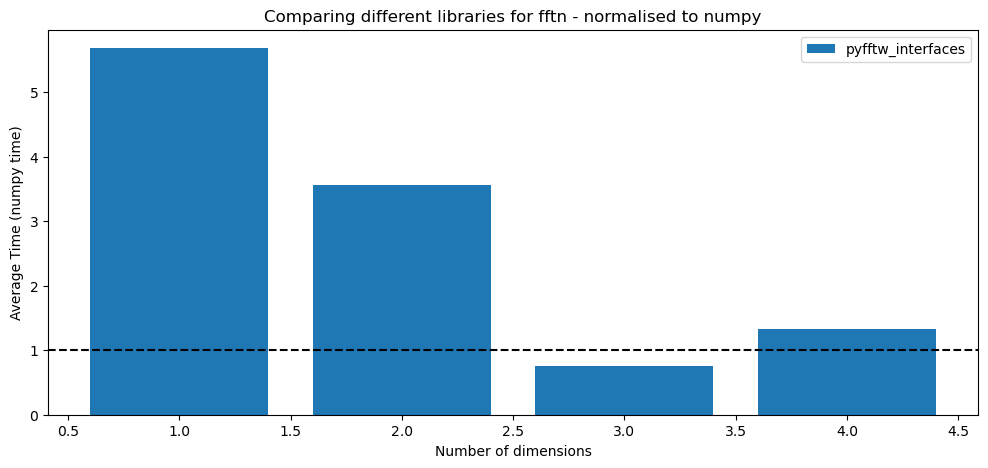

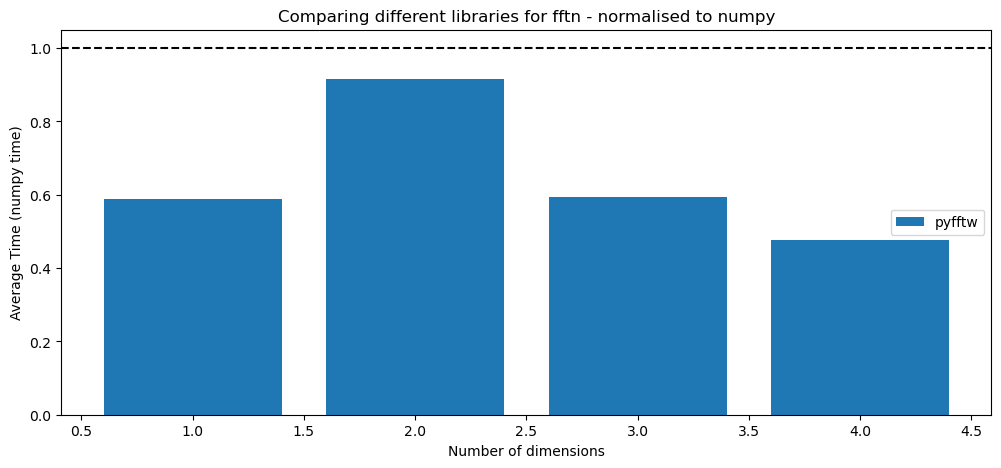

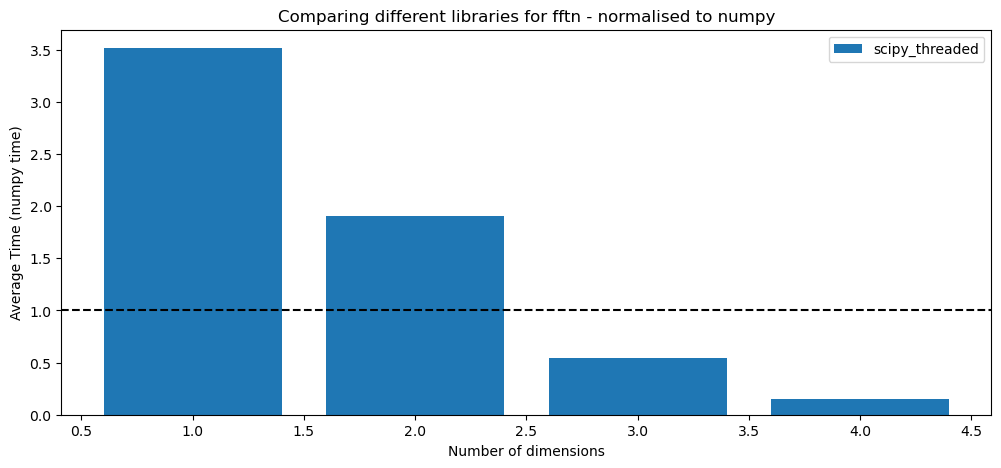

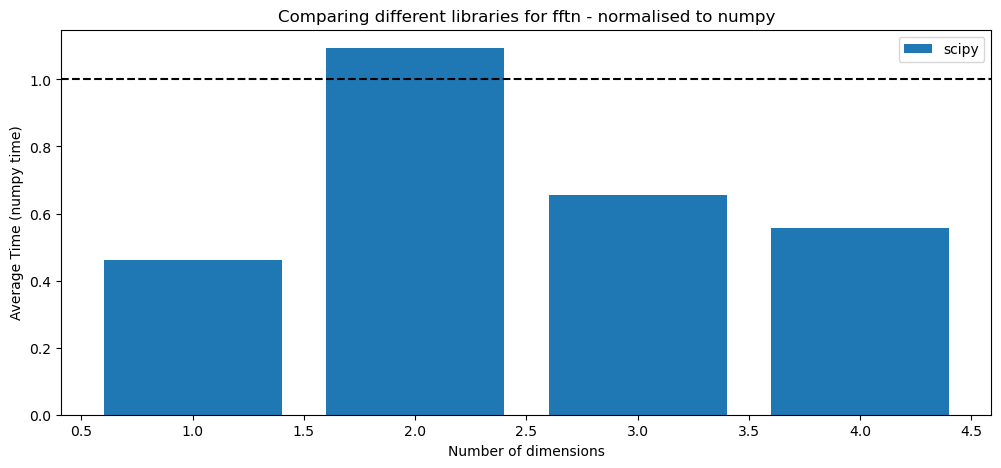

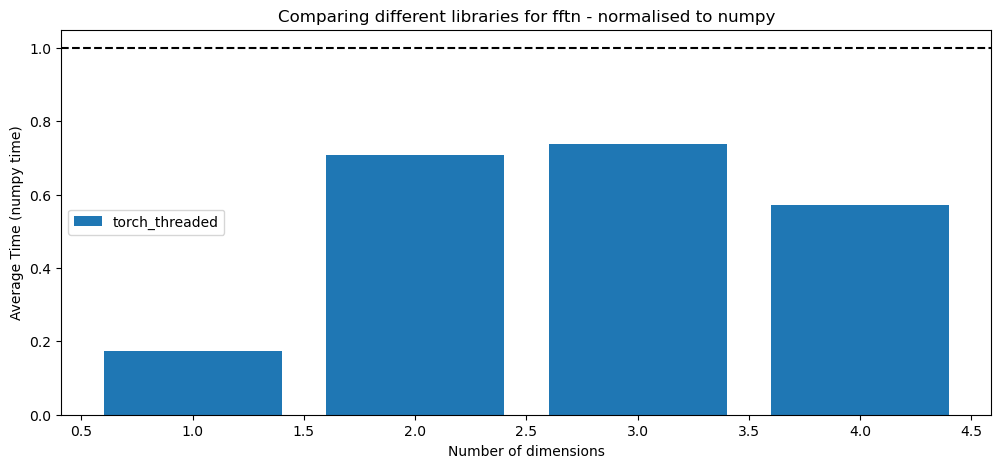

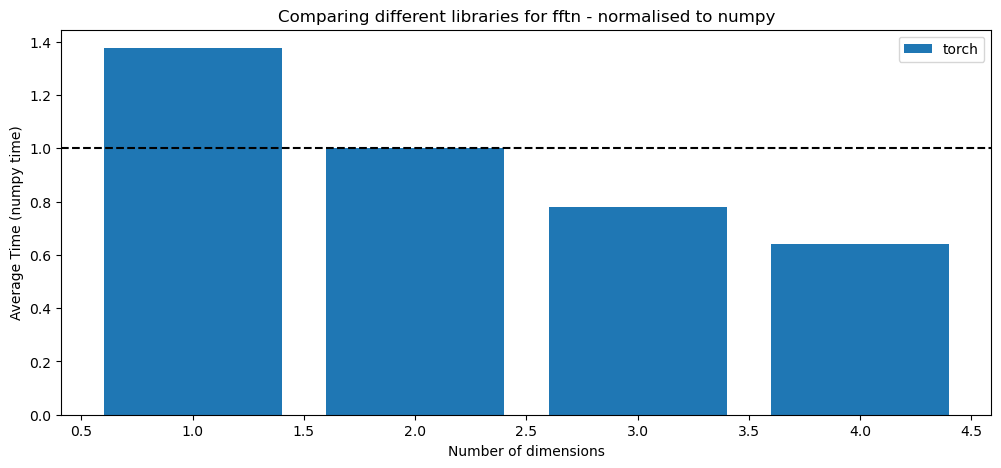

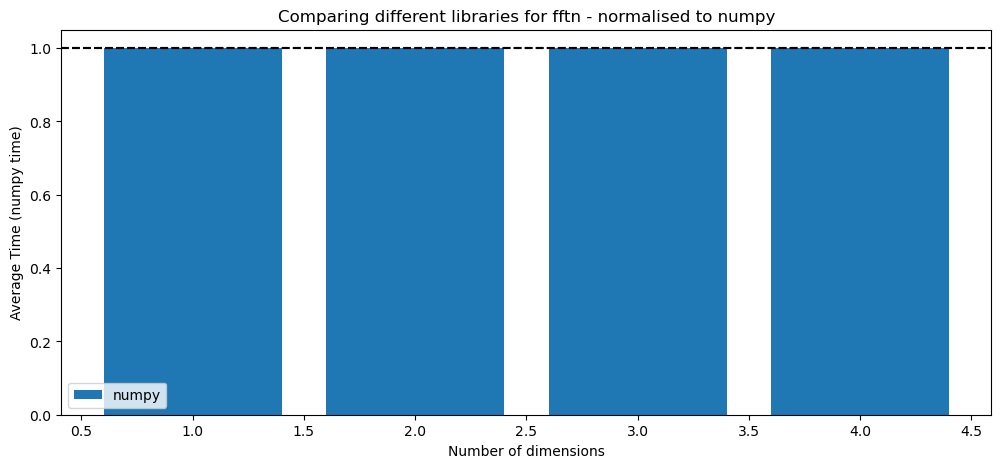

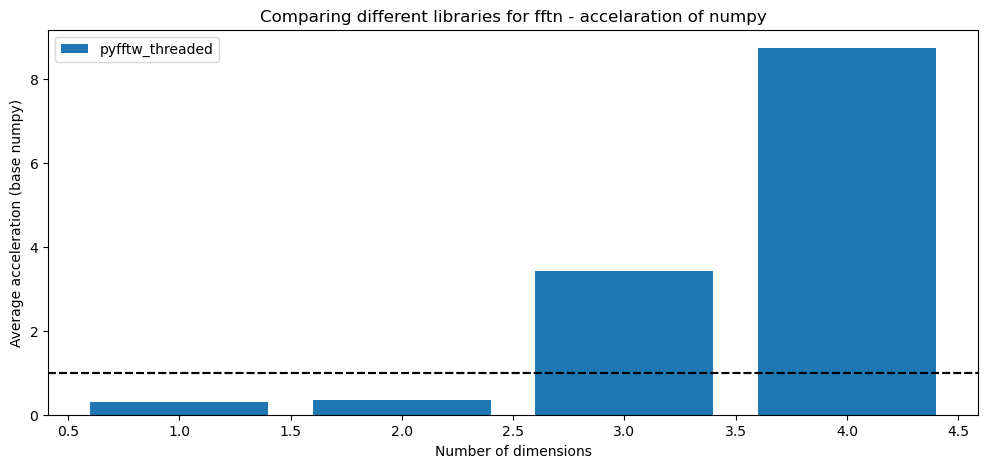

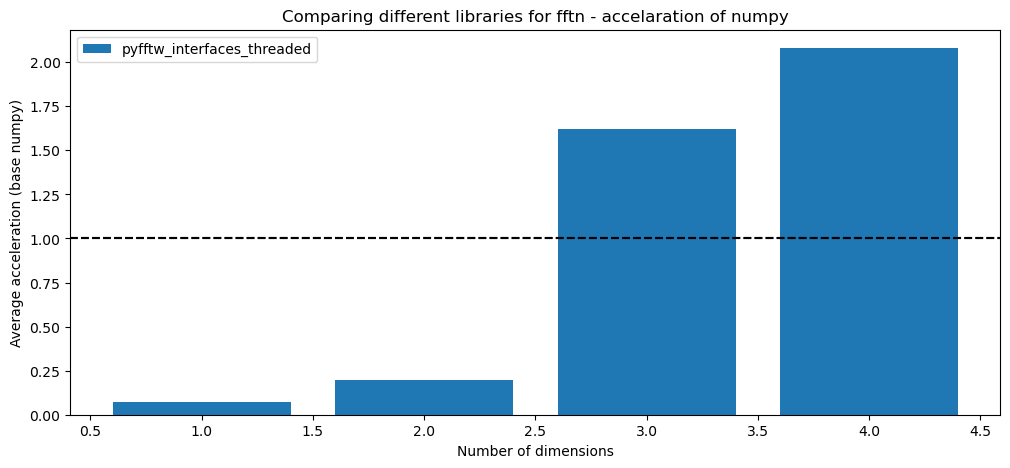

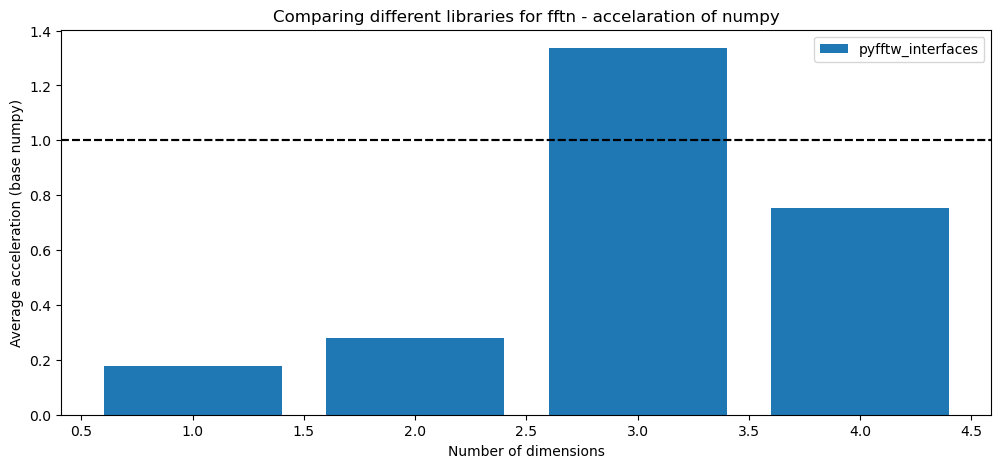

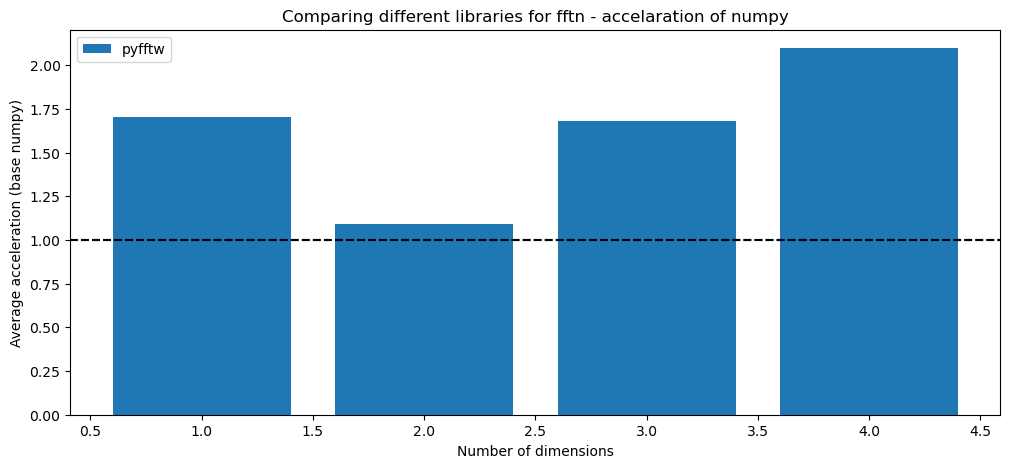

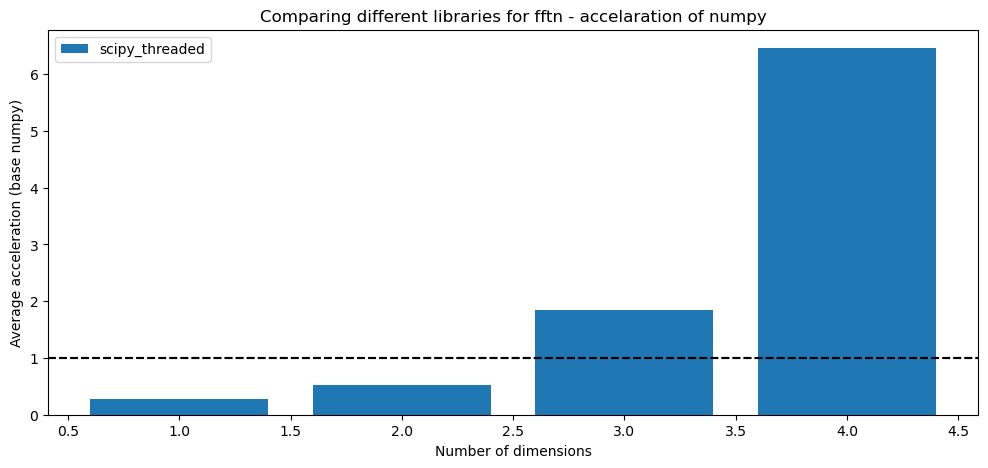

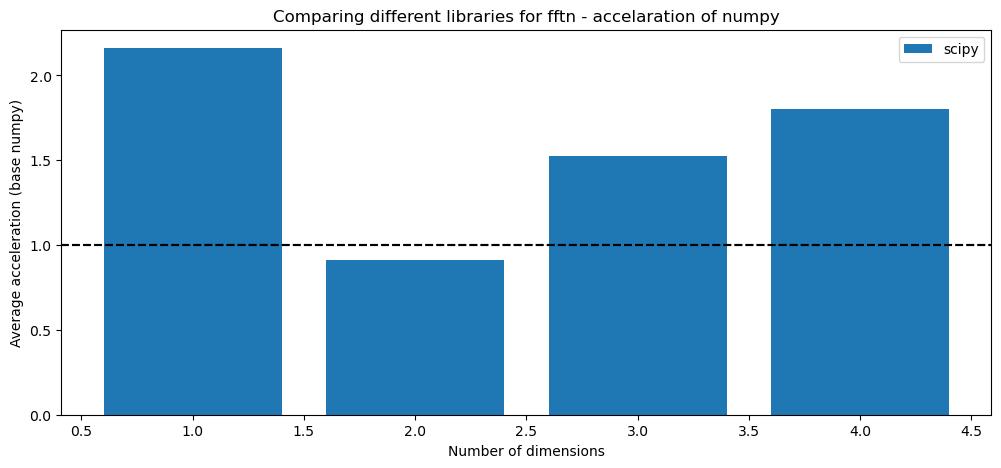

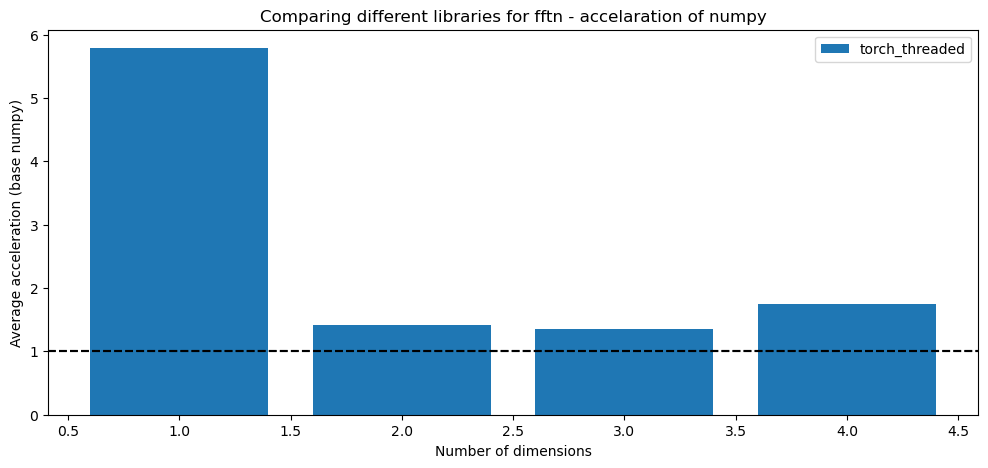

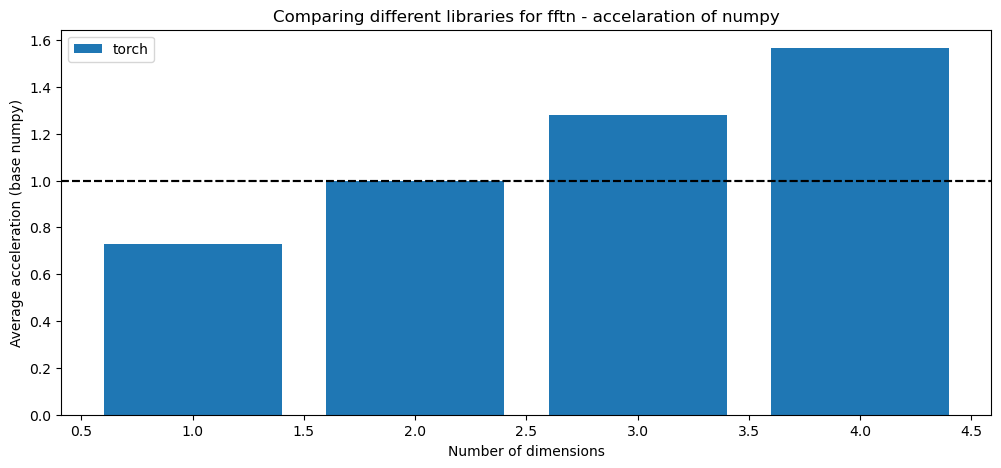

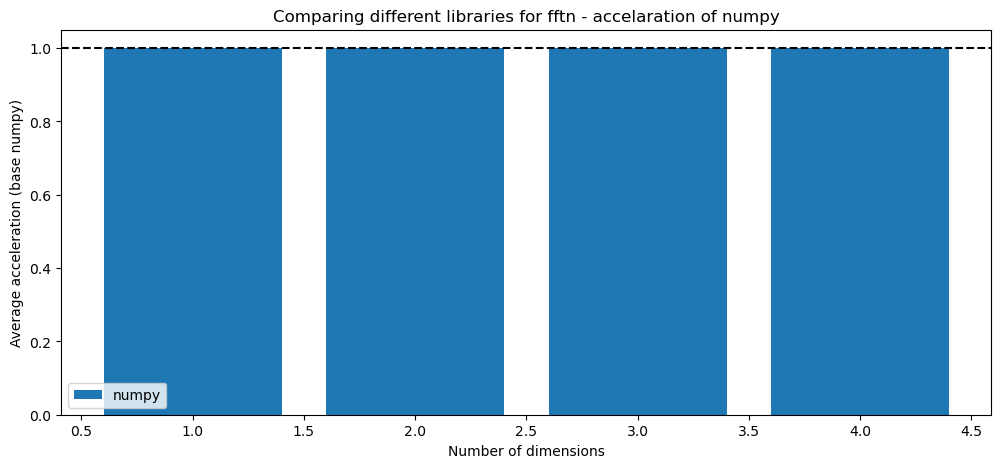

In [243]:
one = average(time_numpy, repeat_time)

plt.figure(figsize=(12, 5))
plt.title('Comparing different libraries for fftn - normalised to numpy')
plt.ylabel('Average Time (numpy time)')
plt.xlabel('Number of dimensions')
plt.bar(range(1, 5), average(time_pyfftw_threaded, repeat_time)/one, label='pyfftw_threaded')
plt.axhline(1, color='black', linestyle='--')   
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.title('Comparing different libraries for fftn - normalised to numpy')
plt.ylabel('Average Time (numpy time)')
plt.xlabel('Number of dimensions')
plt.bar(range(1, 5), average(time_pyfftw_interfaces_threaded, repeat_time)/one, label='pyfftw_interfaces_threaded')
plt.legend()
plt.axhline(1, color='black', linestyle='--')   
plt.show()

plt.figure(figsize=(12, 5))
plt.title('Comparing different libraries for fftn - normalised to numpy')
plt.ylabel('Average Time (numpy time)')
plt.xlabel('Number of dimensions')
plt.bar(range(1, 5), average(time_pyfftw_interfaces, repeat_time)/one, label='pyfftw_interfaces')
plt.legend()
plt.axhline(1, color='black', linestyle='--')   
plt.show()

plt.figure(figsize=(12, 5))
plt.title('Comparing different libraries for fftn - normalised to numpy')
plt.ylabel('Average Time (numpy time)')
plt.xlabel('Number of dimensions')
plt.bar(range(1, 5), average(time_pyfftw, repeat_time)/one, label='pyfftw')
plt.legend()
plt.axhline(1, color='black', linestyle='--')   
plt.show()

plt.figure(figsize=(12, 5))
plt.title('Comparing different libraries for fftn - normalised to numpy')
plt.ylabel('Average Time (numpy time)')
plt.xlabel('Number of dimensions')
plt.bar(range(1, 5), average(time_scipy_threaded, repeat_time)/one, label='scipy_threaded')
plt.legend()
plt.axhline(1, color='black', linestyle='--')   
plt.show()

plt.figure(figsize=(12, 5))
plt.title('Comparing different libraries for fftn - normalised to numpy')
plt.ylabel('Average Time (numpy time)')
plt.xlabel('Number of dimensions')
plt.bar(range(1, 5), average(time_scipy, repeat_time)/one, label='scipy')
plt.legend()
plt.axhline(1, color='black', linestyle='--')   
plt.show()

plt.figure(figsize=(12, 5))
plt.title('Comparing different libraries for fftn - normalised to numpy')
plt.ylabel('Average Time (numpy time)')
plt.xlabel('Number of dimensions')
plt.bar(range(1, 5), average(time_torch_threaded, repeat_time)/one, label='torch_threaded')
plt.legend()
plt.axhline(1, color='black', linestyle='--')   
plt.show()

plt.figure(figsize=(12, 5))
plt.title('Comparing different libraries for fftn - normalised to numpy')
plt.ylabel('Average Time (numpy time)')
plt.xlabel('Number of dimensions')
plt.bar(range(1, 5), average(time_torch, repeat_time)/one, label='torch')
plt.legend()
plt.axhline(1, color='black', linestyle='--')   
plt.show()

plt.figure(figsize=(12, 5))
plt.title('Comparing different libraries for fftn - normalised to numpy')
plt.ylabel('Average Time (numpy time)')
plt.xlabel('Number of dimensions')
plt.bar(range(1, 5), average(time_numpy, repeat_time)/one, label='numpy')
plt.axhline(1, color='black', linestyle='--')   
plt.legend()
plt.axhline(1, color='black', linestyle='--')   
plt.show()

plt.figure(figsize=(12, 5))
plt.title('Comparing different libraries for fftn - accelaration of numpy')
plt.ylabel('Average acceleration (base numpy)')
plt.xlabel('Number of dimensions')
plt.bar(range(1, 5), one/average(time_pyfftw_threaded, repeat_time), label='pyfftw_threaded')
plt.axhline(1, color='black', linestyle='--')   
plt.legend()
plt.axhline(1, color='black', linestyle='--')   
plt.show()

plt.figure(figsize=(12, 5))
plt.title('Comparing different libraries for fftn - accelaration of numpy')
plt.ylabel('Average acceleration (base numpy)')
plt.xlabel('Number of dimensions')
plt.bar(range(1, 5), one/average(time_pyfftw_interfaces_threaded, repeat_time), label='pyfftw_interfaces_threaded')
plt.axhline(1, color='black', linestyle='--')   
plt.legend()
plt.axhline(1, color='black', linestyle='--')   
plt.show()

plt.figure(figsize=(12, 5))
plt.title('Comparing different libraries for fftn - accelaration of numpy')
plt.ylabel('Average acceleration (base numpy)')
plt.xlabel('Number of dimensions')
plt.bar(range(1, 5), one/average(time_pyfftw_interfaces, repeat_time), label='pyfftw_interfaces')
plt.axhline(1, color='black', linestyle='--')   
plt.legend()
plt.axhline(1, color='black', linestyle='--')   
plt.show()

plt.figure(figsize=(12, 5))
plt.title('Comparing different libraries for fftn - accelaration of numpy')
plt.ylabel('Average acceleration (base numpy)')
plt.xlabel('Number of dimensions')
plt.bar(range(1, 5), one/average(time_pyfftw, repeat_time), label='pyfftw')
plt.axhline(1, color='black', linestyle='--')   
plt.legend()
plt.axhline(1, color='black', linestyle='--')   
plt.show()

plt.figure(figsize=(12, 5))
plt.title('Comparing different libraries for fftn - accelaration of numpy')
plt.ylabel('Average acceleration (base numpy)')
plt.xlabel('Number of dimensions')
plt.bar(range(1, 5), one/average(time_scipy_threaded, repeat_time), label='scipy_threaded')
plt.axhline(1, color='black', linestyle='--')   
plt.legend()
plt.axhline(1, color='black', linestyle='--')   
plt.show()

plt.figure(figsize=(12, 5))
plt.title('Comparing different libraries for fftn - accelaration of numpy')
plt.ylabel('Average acceleration (base numpy)')
plt.xlabel('Number of dimensions')
plt.bar(range(1, 5), one/average(time_scipy, repeat_time), label='scipy')
plt.axhline(1, color='black', linestyle='--')   
plt.legend()
plt.axhline(1, color='black', linestyle='--')   
plt.show()

plt.figure(figsize=(12, 5))
plt.title('Comparing different libraries for fftn - accelaration of numpy')
plt.ylabel('Average acceleration (base numpy)')
plt.xlabel('Number of dimensions')
plt.bar(range(1, 5), one/average(time_torch_threaded, repeat_time), label='torch_threaded')
plt.axhline(1, color='black', linestyle='--')   
plt.legend()
plt.axhline(1, color='black', linestyle='--')   
plt.show()

plt.figure(figsize=(12, 5))
plt.title('Comparing different libraries for fftn - accelaration of numpy')
plt.ylabel('Average acceleration (base numpy)')
plt.xlabel('Number of dimensions')
plt.ylabel('Average acceleration (base numpy)')
plt.xlabel('Number of dimensions')
plt.bar(range(1, 5), one/average(time_torch, repeat_time), label='torch')
plt.axhline(1, color='black', linestyle='--')   
plt.legend()
plt.axhline(1, color='black', linestyle='--')   
plt.show()

plt.figure(figsize=(12, 5))
plt.title('Comparing different libraries for fftn - accelaration of numpy')
plt.ylabel('Average acceleration (base numpy)')
plt.xlabel('Number of dimensions')
plt.bar(range(1, 5), one/average(time_numpy, repeat_time), label='numpy')
plt.axhline(1, color='black', linestyle='--')   
plt.legend()
plt.show()


In [47]:
from scipy.linalg import solve
from scipy.sparse.linalg import bicgstab, gmres
import numpy as np
from numpy.linalg import norm

eps = np.finfo(float).eps
n = 100
inf = n/eps
a = np.random.rand(n,n) + 1j * np.random.rand(n,n)
A = np.random.rand(2*n, 2*n) + 1j * np.random.rand(2*n, 2*n)
A[:n, :n] = a
for i in range(n, 2*n):
    A[i,i] = inf
#print(A)


b = np.random.rand(n)
B = np.random.rand(2*n)
B[:n] = b
x, asd = gmres(a, b)
print(norm(a.dot(x)-b))
print(asd)
X, ASD = gmres(A, B)
print(ASD)
print(norm(A.dot(X)-B))
print('Разность векторов')
#print(X[:n] - x)
print(norm(X[:n] - x)/norm(x))
print(norm(a.dot(X[:n]) - b)/norm(b))


2.5903163752321814
1000
2000
312.8056382876145
Разность векторов
43.04902128084314
27.484592677146477
